In [1]:
# import os
# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

import time
import torch
from torch_geometric.loader import DataLoader
import argparse
import yaml
from torch_geometric.nn import radius
from torch.optim import Adam
import torch.autograd.profiler as profiler
from torch.profiler import profile, record_function, ProfilerActivity

from rbfConv import RbfConv
# from dataset import compressedFluidDataset, prepareData

import inspect
import re
def debugPrint(x):
    frame = inspect.currentframe().f_back
    s = inspect.getframeinfo(frame).code_context[0]
    r = re.search(r"\((.*)\)", s).group(1)
    print("{} [{}] = {}".format(r,type(x).__name__, x))
# %matplotlib notebook
import copy

import time
import torch
from torch_geometric.loader import DataLoader
from tqdm.notebook import trange, tqdm
import argparse
import yaml
from torch_geometric.nn import radius
from torch.optim import Adam
import torch.autograd.profiler as profiler
from torch.profiler import profile, record_function, ProfilerActivity

from rbfConv import RbfConv
from dataset import compressedFluidDataset, prepareData

import inspect
import re
def debugPrint(x):
    frame = inspect.currentframe().f_back
    s = inspect.getframeinfo(frame).code_context[0]
    r = re.search(r"\((.*)\)", s).group(1)
    print("{} [{}] = {}".format(r,type(x).__name__, x))


import tomli
from scipy.optimize import minimize
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
from matplotlib.ticker import MaxNLocator
import matplotlib.ticker as mticker
import matplotlib.pyplot as plt

seed = 0


import random 
import numpy as np
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
# print(torch.cuda.device_count())
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# print('running on: ', device)
torch.set_num_threads(1)

from joblib import Parallel, delayed

from cutlass import *
from rbfConv import *
from tqdm.notebook import tqdm

from datautils import *
# from sphUtils import *
from lossFunctions import *

from plotting import *
plt.style.use('dark_background')
from tqdm.notebook import trange, tqdm
import shlex as shlex

In [265]:

# from rbfNet import *
# from tqdm.notebook import trange, tqdm

parser = argparse.ArgumentParser()
parser.add_argument('-e','--epochs', type=int, default=25)
parser.add_argument('-cmap','--coordinateMapping', type=str, default='preserving')
parser.add_argument('-w','--windowFunction', type=str, default='poly6')
parser.add_argument('-c','--cutoff', type=int, default=127)
parser.add_argument('-b','--batch_size', type=int, default=2)
parser.add_argument('-o','--output', type = str, default = 'trainingData')
parser.add_argument('--cutlassBatchSize', type=int, default=128)
parser.add_argument('-r','--lr', type=float, default=0.01)
parser.add_argument('--lr_decay_factor', type=float, default=0.9)
parser.add_argument('--lr_decay_step_size', type=int, default=1)
parser.add_argument('--weight_decay', type=float, default=0)
parser.add_argument('-x','--rbf_x', type=str, default='linear')
parser.add_argument('-y','--rbf_y', type=str, default='linear')
parser.add_argument('-n','--n', type=int, default=4)
parser.add_argument('-m','--m', type=int, default=4)
parser.add_argument('--seed', type=int, default=42)
parser.add_argument('--networkseed', type=int, default=42)
parser.add_argument('-d','--frameDistance', type=int, default=1)
parser.add_argument('--dataDistance', type=int, default=1)
parser.add_argument('--gpu', type=int, default=0)
parser.add_argument('--gpus', type=int, default=1)
parser.add_argument('-f','--forwardLoss', type=bool, default=False)
parser.add_argument('-v','--verbose', type=bool, default=False)
parser.add_argument('-l','--li', type=bool, default=True)
parser.add_argument('-a','--activation', type=str, default='relu')
parser.add_argument('--arch', type=str, default='32 64 64 3')
parser.add_argument('--limitData', type=int, default=-1)
parser.add_argument('--iterations', type=int, default=1000)
parser.add_argument('-u', '--maxUnroll', type=int, default=10)
parser.add_argument('--minUnroll', type=int, default=2)
parser.add_argument('-augj', '--augmentJitter', type=bool, default=True)
parser.add_argument('-j', '--jitterAmount', type=float, default=0.01)
parser.add_argument('-augr', '--augmentAngle', type=bool, default=False)
parser.add_argument('-adjust', '--adjustForFrameDistance', type = bool, default = False)
parser.add_argument('-netArch', '--network', type=str, default='default')
parser.add_argument('-norm', '--normalized', type=bool, default=False)

args = parser.parse_args(shlex.split("--frameDistance 1 -n 4 -m 4 --arch '32 64 64 3' -x 'fourier' -y 'fourier' -w None -cmap cartesian --epochs 25 --networkseed 209652396 -netArch default --output paperData_collision"))


In [266]:

if args.verbose:
    print('Setting all rng seeds to %d' % args.seed)
import random 
import numpy as np

random.seed(args.seed)
torch.manual_seed(args.seed)
torch.cuda.manual_seed(args.seed)
np.random.seed(args.seed)

if args.verbose:
    print('Available cuda devices:', torch.cuda.device_count())
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if args.verbose:
    print('Running on Device %s' % device)
torch.set_num_threads(1)

# from joblib import Parallel, delayed

from cutlass import *
from rbfConv import *
from datautils import *
from plotting import *

# Use dark theme
plt.style.use('dark_background')
from tqdm import tqdm
import os

from rbfNet import *


if args.verbose:
    print('Parsing data in ../export')
basePath = '../export'
# basePath = os.path.expanduser('~/dev/datasets/generativeCollisions')
basePath = os.path.expanduser('/mnt/data/datasets/generativeCollisions')

trainingFiles = [basePath + '/train/' + f for f in os.listdir(basePath + '/train/') if f.endswith('.hdf5')]

training = []
validation = []
testing = []

    
    # for s in simulationFiles:    
#     _, train, valid, test = splitFileZSTD(s, split = True, limitRollOut = False, skip = 0, cutoff = 1800, distance = 1)
#     training.append((s,train))
#     validation.append((s,valid))
#     testing.append((s,test))
# debugPrint(training)

# simulationFiles = [basePath + '/' + f for f in os.listdir(basePath) if f.endswith('.hdf5')]

if args.limitData > 0:
    files = []
    for i in range(max(len(trainingFiles), args.limitData)):
        files.append(trainingFiles[i])
    simulationFiles = files
# simulationFiles = [simulationFiles[0]]
if args.verbose:
    print('Input files:')
    for i, c in enumerate(trainingFiles):
        print('\t', i ,c)

training = []
validation = []
testing = []

for s in trainingFiles:
    f, s, u = splitFile(s, split = False, cutoff = -args.frameDistance * args.maxUnroll, skip = args.frameDistance if args.adjustForFrameDistance else 0)
    training.append((f, (s,u)))

In [267]:
train_ds = datasetLoader(training)
print(len(train_ds))

7360


In [268]:
from tqdm.notebook import tqdm

In [269]:
len(train_ds)

7360

In [270]:
train_ds[0]

('/mnt/data/datasets/generativeCollisions/train/collision - 2023-08-01_00-14-50.hdf5',
 0,
 8)

In [277]:
# data = position | velocity | gravity | features
iterator = iter(train_ds)
file, frame, r = train_ds[0]
attributes, inputData, groundTruthData = loadFrame(file, frame, 1 + np.arange(1), 1)

dataCache = torch.zeros((len(train_ds), inputData['fluidPosition'].shape[0], 12))

for i in tqdm(range(len(train_ds))):
#     i = next(iterator)
#     print(i)
#     frameData = 
    file, frame, r = train_ds[i]
    attributes, inputData, groundTruthData = loadFrame(file, frame, 1 + np.arange(1), 1)
#     fluidPositions = inputData['fluidPosition']
    fluidPositions, boundaryPositions, fluidFeatures, boundaryFeatures = constructFluidFeatures(attributes, inputData)
#     print(fluidFeatures.shape)
#     fluidPositions, boundaryPositions, fluidFeatures, boundaryFeatures, fluidGravity, fluidBatches, boundaryBatches, groundTruths, attributes = \
#     loadBatch(train_ds, [i], constructFluidFeatures, unroll, args.frameDistance, augmentAngle = args.augmentAngle, augmentJitter = args.augmentJitter, jitterAmount = 0.0, adjustForFrameDistance = args.adjustForFrameDistance)  

    difference = fluidPositions - torch.tensor([0,0], dtype = fluidPositions.dtype, device = fluidPositions.device)
    # print(difference)
    distance = torch.linalg.norm(difference,axis=1) + 1e-7
    difference = difference / distance[:, None]
    fluidGravity = -0.5 * 10**2 * difference * (distance)[:,None]**2
#     print('Fluid Gravity (Computed): ', fluidGravity)
    
#     cachedData = torch.zeros((fluidPositions.shape[0], fluidPositions.shape[1] + inputData['fluidVelocity'].shape[1] + fluidGravity.shape[1] + fluidFeatures.shape[1]))
    dataCache[i,:,0:2] = fluidPositions
    dataCache[i,:,2:4] = inputData['fluidVelocity']
    dataCache[i,:,4:6] = fluidGravity
    dataCache[i,:,6:10] = fluidFeatures
    dataCache[i,:,10:] = groundTruthData[0][:,:2]
#     dataCache.append(cachedData)
#     break

print(dataCache.shape)


  0%|          | 0/7360 [00:00<?, ?it/s]

torch.Size([7360, 3130, 12])


In [4]:
# for s in tqdm(validationFiles):
#     f, s, u = splitFile(s, split = False, cutoff = -4, skip = 0)
#     validation.append((f, (s,u)))
    
if args.verbose:
    print('Processed data into datasets:')
    debugPrint(training)
    debugPrint(validation)
    debugPrint(testing)

batch_size = args.batch_size

if args.verbose:
    print('Setting up data loaders')
train_ds = datasetLoader(training)
train_dataloader = DataLoader(train_ds, shuffle=True, batch_size = batch_size).batch_sampler


In [176]:
# print(training)
print(train_ds[0])

('/mnt/data/datasets/generativeCollisions/train/collision - 2023-08-01_00-14-50.hdf5', 1, 8)


<IPython.core.display.Javascript object>


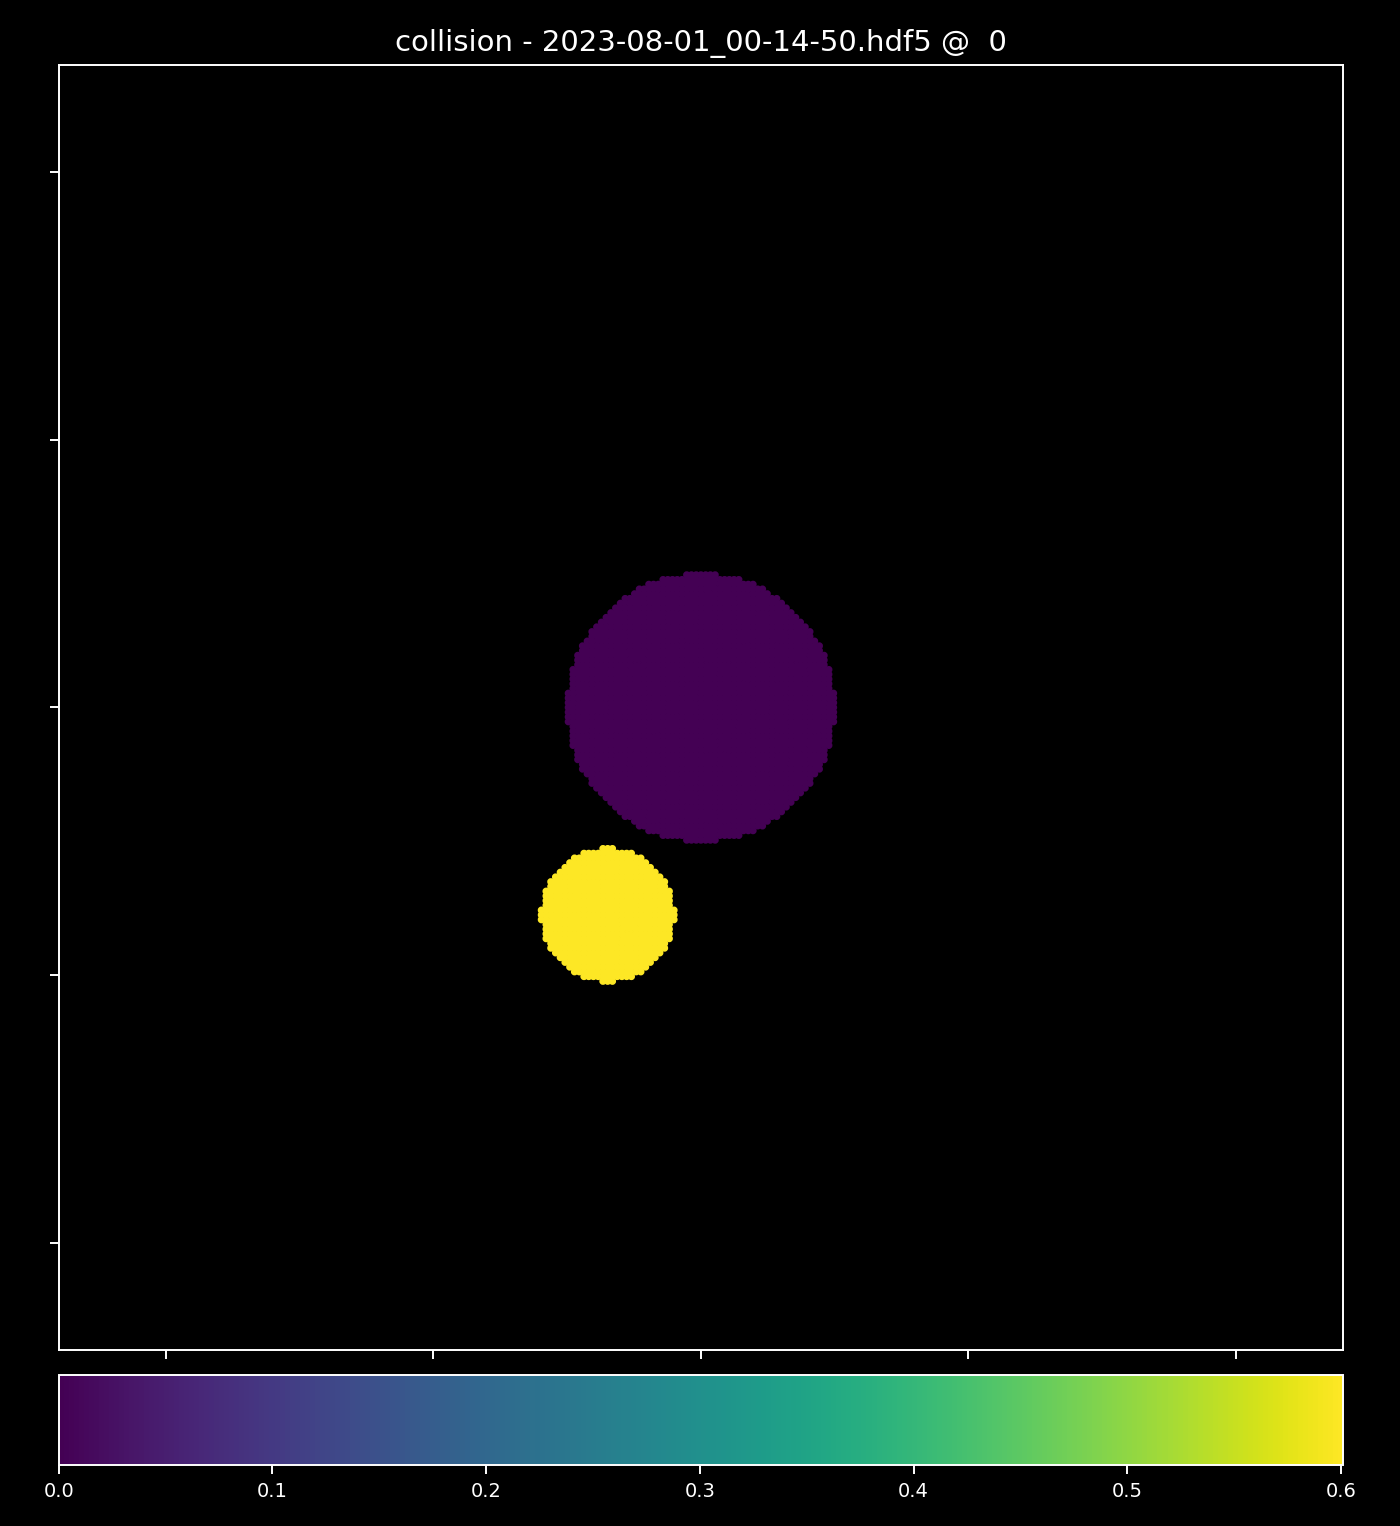

/home/winchenbach/anaconda3/envs/torch_env/lib/python3.9/site-packages/ipykernel/pylab/backend_inline.py:11: DeprecationWarning: `ipykernel.pylab.backend_inline` is deprecated, directly use `matplotlib_inline.backend_inline`
  warnings.warn(


interactive(children=(Dropdown(description='file', options=('/mnt/data/datasets/generativeCollisions/train/col…

<function __main__.plotNetwork(file, frame)>

In [182]:

fig, axis = plt.subplots(1, 1, figsize=(8,8*1.09), sharex = False, sharey = False, squeeze = False)

attributes, inputData, groundTruthData = loadFrame(trainingFiles[0], 0, 1 + np.arange(1), 1)


x = inputData['fluidPosition'][:,0].detach().cpu().numpy()
y = inputData['fluidPosition'][:,1].detach().cpu().numpy()

# v = (gt[:,-1:] - modelOutput) ** 2
v = torch.linalg.norm(inputData['fluidVelocity'],dim=1)

axis[0,0].set_title('Velocity')
# sc = axis[1,0].scatter(x,y,c = v,s=0.25)
GTsc = axis[0,0].scatter(x,y,c = v.detach().cpu().numpy(), s= 4)
axis[0,0].axis('equal')
axis[0,0].set_xlim(-1.2,1.2)
axis[0,0].set_ylim(-1.2,1.2)
# axis[0,1].axvline(-2)
# axis[0,1].axvline(2)
# axis[0,1].axhline(-2)
# axis[0,1].axhline(2)
axis[0,0].scatter(inputData['boundaryPosition'][:,0], inputData['boundaryPosition'][:,1], c = 'white', s =2 )
axis[0,0].set_xticklabels([])
axis[0,0].set_yticklabels([])
ax1_divider = make_axes_locatable(axis[0,0])
cax1 = ax1_divider.append_axes("bottom", size="7%", pad="2%")
GTcbar = fig.colorbar(GTsc, cax=cax1,orientation='horizontal')
GTcbar.ax.tick_params(labelsize=8) 
fig.tight_layout()


def plotNetwork(file, frame):
    attributes, inputData, groundTruthData = loadFrame(file, frame, 1 + np.arange(1), 1)

    data = inputData['fluidDensity'].detach().cpu().numpy()
    positions = inputData['fluidPosition'].detach().cpu().numpy()
    
    data = torch.linalg.norm(inputData['fluidVelocity'],dim=1).detach().cpu().numpy()
#     debugPrint(data.shape)
    positions = inputData['fluidPosition'].detach().cpu().numpy()
    GTsc.set_offsets(positions)
    GTsc.set_array(data)
    GTcbar.mappable.set_clim(vmin=np.min(data), vmax=np.max(data))

    axis[0,0].set_title('%s @ %2d' % (file.split('/')[-1], frame))
    fig.canvas.draw()
    fig.canvas.flush_events()



# plotNetwork(simulationFiles[0], 0, subfolders[0], epochs - 1)

interact(plotNetwork, file = trainingFiles, frame = widgets.IntSlider(value=0, min=0, max=128 -1, step=1))



In [5]:

def loadData(dataset, index, featureFun, unroll = 1, frameDistance = 1, augmentAngle = 0., augmentJitter = 0., adjustForFrameDistance = True):
    with record_function("load data - hdf5"): 
        fileName, frameIndex, maxRollouts = dataset[index]

        attributes, inputData, groundTruthData = loadFrame(fileName, frameIndex, 1 + np.arange(unroll), frameDistance = frameDistance, adjustForFrameDistance = adjustForFrameDistance)
        # attributes['support'] = 4.5 * attributes['support']
        if augmentAngle != 0 or augmentJitter != 0:
            attributes, inputData, groundTruthData = augment(attributes, inputData, groundTruthData, augmentAngle, augmentJitter)
        fluidPositions, boundaryPositions, fluidFeatures, boundaryFeatures = featureFun(attributes, inputData)

        return attributes, fluidPositions, boundaryPositions, fluidFeatures, boundaryFeatures, inputData['fluidGravity'], groundTruthData

def loadBatch(train_ds, bdata, featureFun, unroll = 1, frameDistance = 1, augmentAngle = False, augmentJitter = False, jitterAmount = 0.01, adjustForFrameDistance = True):
    with record_function("load batch - hdf5"): 
        fluidPositions = []
        boundaryPositions = []
        fluidFeatures = []
        boundaryFeatures = []
        fluidBatchIndices = []
        boundaryBatchIndices = []
        groundTruths = []
        fluidGravities = []
        attributeArray = []
        for i in range(unroll):
            groundTruths.append([])

        for i,b in enumerate(bdata):
            with record_function("load batch - hdf5[batch]"): 
        #         debugPrint(i)
        #         debugPrint(b)
                attributes, fluidPosition, boundaryPosition, fluidFeature, boundaryFeature, fluidGravity, groundTruth = loadData(train_ds, b, featureFun, unroll = unroll, frameDistance = frameDistance,\
                                augmentAngle = torch.rand(1)[0] if augmentAngle else 0., augmentJitter = jitterAmount if augmentJitter else 0., adjustForFrameDistance = adjustForFrameDistance)     
        #         debugPrint(groundTruth)
                fluidPositions.append(fluidPosition)
                attributeArray.append(attributes)
        #         debugPrint(fluidPositions)
#                 boundaryPositions.append(boundaryPosition)
                fluidFeatures.append(fluidFeature)
#                 boundaryFeatures.append(boundaryFeature)
                
                fluidGravities.append(fluidGravity)

                batchIndex = torch.ones(fluidPosition.shape[0]) * i
                fluidBatchIndices.append(batchIndex)

#                 batchIndex = torch.ones(boundaryPosition.shape[0]) * i
#                 boundaryBatchIndices.append(batchIndex)
                for u in range(unroll):
                    groundTruths[u].append(groundTruth[u])

        fluidPositions = torch.vstack(fluidPositions)
#         boundaryPositions = torch.vstack(boundaryPositions)
        fluidFeatures = torch.vstack(fluidFeatures)
#         boundaryFeatures = torch.vstack(boundaryFeatures)
        fluidGravities = torch.vstack(fluidGravities)
        fluidBatchIndices = torch.hstack(fluidBatchIndices)
#         boundaryBatchIndices = torch.hstack(boundaryBatchIndices)
        for u in range(unroll):
            groundTruths[u] = torch.vstack(groundTruths[u])

        return fluidPositions, None, fluidFeatures, None, fluidGravities, fluidBatchIndices, None, groundTruths, attributeArray


In [6]:
# fluidPositions, boundaryPositions, fluidFeatures, boundaryFeatures, fluidGravity, fluidBatches, boundaryBatches, groundTruths, attributes = \
#     loadBatch(train_ds, bdata, constructFluidFeatures, unroll, frameDistance, augmentAngle = False, augmentJitter = False, jitterAmount = 0.0, adjustForFrameDistance = False)    

In [105]:
def constructFluidFeatures(attributes, inputData):
    fluidFeatures = torch.hstack(\
                (torch.ones(inputData['fluidArea'].shape[0]).type(torch.float32).unsqueeze(dim=1), \
                 inputData['fluidVelocity'].type(torch.float32), 
                 torch.zeros(inputData['fluidArea'].shape[0]).type(torch.float32).unsqueeze(dim=1)))    
    
    boundaryFeatures = None 
    return inputData['fluidPosition'].type(torch.float32), None, fluidFeatures, None


if args.verbose:
    print('Setting up network parameters:')
fileName, frameIndex, maxRollout = train_ds[len(train_ds)//2]
attributes, inputData, groundTruthData = loadFrame(fileName, frameIndex, 1 + np.arange(1))

fluidPositions, boundaryPositions, fluidFeatures, boundaryFeatures = constructFluidFeatures(attributes, inputData)


In [107]:
print(fluidPositions, fluidFeatures)

tensor([[0.1322, 0.2720],
        [0.1411, 0.2720],
        [0.1499, 0.2720],
        ...,
        [0.0088, 0.2477],
        [0.0177, 0.2477],
        [0.0266, 0.2477]]) tensor([[ 1.0000e+00, -4.0458e-01, -4.7686e-01,  0.0000e+00],
        [ 1.0000e+00, -4.0385e-01, -4.7708e-01,  0.0000e+00],
        [ 1.0000e+00, -4.0308e-01, -4.7748e-01,  0.0000e+00],
        ...,
        [ 1.0000e+00, -1.8789e-04, -5.8785e-03,  0.0000e+00],
        [ 1.0000e+00, -2.5798e-04, -6.0778e-03,  0.0000e+00],
        [ 1.0000e+00,  1.7439e-04, -6.1728e-03,  0.0000e+00]])


In [8]:
# fig, axis = plt.subplots(3, 2, figsize=(12,12), sharex = False, sharey = False, squeeze = False)

# def scatter(fig, axis, x, y, c, title):
#     im = axis.scatter(x, y, c = c)
#     axis.axis([-1, 1, -1, 1])
#     axis.set_aspect('equal', adjustable='box')
#     ax1_divider = make_axes_locatable(axis)
#     cax1 = ax1_divider.append_axes("right", size="2%", pad="6%")
#     cb1 = fig.colorbar(im, cax=cax1,orientation='vertical')
#     cb1.ax.tick_params(labelsize=8) 
#     axis.set_title(title)
    
# scatter(fig, axis[0,0], fluidPositions[:,0], fluidPositions[:,1], fluidFeatures[:,0], 'ones')
# scatter(fig, axis[0,1], fluidPositions[:,0], fluidPositions[:,1], fluidFeatures[:,-1], 'zeros')

# scatter(fig, axis[1,0], fluidPositions[:,0], fluidPositions[:,1], fluidFeatures[:,1], 'v.x')
# scatter(fig, axis[1,1], fluidPositions[:,0], fluidPositions[:,1], fluidFeatures[:,2], 'v.y')

# scatter(fig, axis[2,0], fluidPositions[:,0], fluidPositions[:,1], inputData['fluidGravity'][:,0], 'a.x')
# scatter(fig, axis[2,1], fluidPositions[:,0], fluidPositions[:,1], inputData['fluidGravity'][:,1], 'a.y')

# fig.tight_layout()

In [156]:
n = args.n
m = args.m
coordinateMapping = args.coordinateMapping
windowFn = getWindowFunction(args.windowFunction)
rbf_x = args.rbf_x
rbf_y = args.rbf_y
initialLR = args.lr
maxRollOut = 10
epochs = args.epochs
frameDistance = args.frameDistance

# if args.verbose:
print('Network Hyperparameters:')
print('[n x m]: [%dx%d]'% (n, m))
print('[rbf_x x rbf_y]: [%sx%s]'% (rbf_x, rbf_y))
print('Mapping:', args.coordinateMapping)
print('window function:', args.windowFunction)
print('activation function:', args.activation)
print('initial learning rate: ', initialLR)
print('Training for %d epochs' % epochs)
print('Rollout limit (if applicable):', maxRollout)
print('Training with frame offset of', frameDistance)
print('Network architecture', args.arch)


widths = args.arch.strip().split(' ')
layers = [int(s) for s in widths]
# debugPrint(layers)
if args.verbose:
    print('Building Network')

random.seed(args.networkseed)
torch.manual_seed(args.networkseed)
torch.cuda.manual_seed(args.networkseed)
np.random.seed(args.networkseed)


model = None
if args.network == 'default':
    model = RbfNet(fluidFeatures.shape[1], boundaryFeatures.shape[1] if boundaryFeatures is not None else 0, layers = layers, coordinateMapping = coordinateMapping, n = n, m = m, windowFn = windowFn, rbf_x = rbf_x, rbf_y = rbf_y, batchSize = args.cutlassBatchSize, normalized = args.normalized)
if args.network == 'split':
    model = RbfSplitNet(fluidFeatures.shape[1], boundaryFeatures.shape[1] if boundaryFeatures is not None else 0, layers = layers, coordinateMapping = coordinateMapping, n = n, m = m, windowFn = windowFn, rbf_x = rbf_x, rbf_y = rbf_y, batchSize = args.cutlassBatchSize, normalized = args.normalized)
if args.network == 'interleaved':
    model = RbfInterleaveNet(fluidFeatures.shape[1], boundaryFeatures.shape[1] if boundaryFeatures is not None else 0, layers = layers, coordinateMapping = coordinateMapping, n = n, m = m, windowFn = windowFn, rbf_x = rbf_x, rbf_y = rbf_y, batchSize = args.cutlassBatchSize, normalized = args.normalized)
if args.network == 'input':
    model = RbfInputNet(fluidFeatures.shape[1], boundaryFeatures.shape[1] if boundaryFeatures is not None else 0, layers = layers, coordinateMapping = coordinateMapping, n = n, m = m, windowFn = windowFn, rbf_x = rbf_x, rbf_y = rbf_y, batchSize = args.cutlassBatchSize, normalized = args.normalized)
if args.network == 'output':
    model = RbfOutputNet(fluidFeatures.shape[1], boundaryFeatures.shape[1] if boundaryFeatures is not None else 0, layers = layers, coordinateMapping = coordinateMapping, n = n, m = m, windowFn = windowFn, rbf_x = rbf_x, rbf_y = rbf_y, batchSize = args.cutlassBatchSize, normalized = args.normalized)


lr = initialLR
optimizer = Adam(model.parameters(), lr=lr, weight_decay=args.weight_decay)
model = model.to(device)


Network Hyperparameters:
[n x m]: [4x4]
[rbf_x x rbf_y]: [fourierxfourier]
Mapping: cartesian
window function: None
activation function: relu
initial learning rate:  0.01
Training for 25 epochs
Rollout limit (if applicable): 8
Training with frame offset of 1
Network architecture 32 64 64 3


In [157]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
if args.gpus == 1:
    print('Number of parameters', count_parameters(model))

Number of parameters 145030


In [158]:

optimizer.zero_grad()
model.train()

hyperParameterDict = {}
hyperParameterDict['n'] = n
hyperParameterDict['m'] = m
hyperParameterDict['coordinateMapping'] = coordinateMapping
hyperParameterDict['rbf_x'] = rbf_x
hyperParameterDict['rbf_y'] = rbf_y
hyperParameterDict['windowFunction'] =  args.windowFunction
hyperParameterDict['liLoss'] = 'yes' if args.li else 'no'
hyperParameterDict['initialLR'] = initialLR
hyperParameterDict['maxRollOut'] = maxRollOut
hyperParameterDict['epochs'] = epochs
hyperParameterDict['frameDistance'] = frameDistance
hyperParameterDict['dataDistance'] = args.dataDistance
hyperParameterDict['parameters'] =  count_parameters(model)
hyperParameterDict['cutoff'] =  args.cutoff
hyperParameterDict['dataLimit'] =  args.limitData 
hyperParameterDict['arch'] =  args.arch
hyperParameterDict['seed'] =  args.seed
hyperParameterDict['minUnroll'] =  args.minUnroll
hyperParameterDict['maxUnroll'] =  args.maxUnroll
hyperParameterDict['augmentAngle'] =  args.augmentAngle
hyperParameterDict['augmentJitter'] =  args.augmentJitter
hyperParameterDict['jitterAmount'] =  args.jitterAmount
hyperParameterDict['networkSeed'] =  args.networkseed
hyperParameterDict['network'] = args.network
hyperParameterDict['normalized'] = args.normalized
hyperParameterDict['adjustForFrameDistance'] = args.adjustForFrameDistance
lr = initialLR


timestamp = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
networkPrefix = args.network

exportString = '%s - n=[%2d,%2d] rbf=[%s,%s] map = %s window = %s d = %2d e = %2d arch %s distance = %2d - %s seed %s' % (networkPrefix, hyperParameterDict['n'], hyperParameterDict['m'], hyperParameterDict['rbf_x'], hyperParameterDict['rbf_y'], hyperParameterDict['coordinateMapping'], args.windowFunction, hyperParameterDict['frameDistance'], hyperParameterDict['epochs'], args.arch, frameDistance, timestamp, args.networkseed)

shortLabel = '%14s [%14s] - %s -> [%16s, %16s] x [%2d, %2d] @ %2s ' % (hyperParameterDict['windowFunction'], hyperParameterDict['arch'], hyperParameterDict['coordinateMapping'], hyperParameterDict['rbf_x'], hyperParameterDict['rbf_y'], hyperParameterDict['n'], hyperParameterDict['m'],hyperParameterDict['networkSeed'])
# print(shortLabel)

# exit()
# if args.gpus == 1:


In [159]:
print(shortLabel)

          None [    32 64 64 3] - cartesian -> [         fourier,          fourier] x [ 4,  4] @ 209652396 


In [160]:

# exit()
# if args.gpus == 1:

#     debugPrint(hyperParameterDict)
# if args.gpus == 1:
#     debugPrint(exportString)
if args.verbose:
    print('Writing output to ./%s/%s' % (args.output, exportString))

# exportPath = './trainingData/%s - %s.hdf5' %(self.config['export']['prefix'], timestamp)
if not os.path.exists('./%s/%s' % (args.output, exportString)):
    os.makedirs('./%s/%s' % (args.output, exportString))
# self.outFile = h5py.File(self.exportPath,'w')


In [177]:
%matplotlib notebook

In [190]:
augmentAngle = args.augmentAngle
augmentJitter = args.augmentJitter
jitterAmount = args.jitterAmount
adjustForFrameDistance = args.adjustForFrameDistance
frameDistance = args.frameDistance
unroll = 1
bdata = [16]

print('Augment Angle:', augmentAngle)
print('Augment Jitter:', augmentJitter)
print('Jitter Amount:', jitterAmount)
print('Adjust for Multistep:', adjustForFrameDistance)
print('Frame Distance', args.frameDistance)
print('Unroll steps', unroll, '(%d : %d)' % (args.minUnroll, args.maxUnroll))
print('Test Batch', bdata)

Augment Angle: False
Augment Jitter: True
Jitter Amount: 0.01
Adjust for Multistep: True
Frame Distance 1
Unroll steps 1 (2 : 10)
Test Batch [16]


In [287]:
bdata = [0]
unroll = 4

dataRows = torch.zeros((len(bdata), unroll, dataCache.shape[1], dataCache.shape[2]))

for ib, b in enumerate(bdata):
    for iu, u in enumerate(range(unroll)):
        currRow = dataCache[b + iu,:,:]
        dataRows[ib, iu, :, :] = currRow
dataRows = dataRows.to(device) 
print(dataRows.shape)

torch.Size([1, 4, 3130, 12])


In [191]:
bdata = [0,-1]
unroll = 4

dataRows = torch.zeros((len(bdata), unroll, dataCache.shape[1], dataCache.shape[2])

fluidPositions, boundaryPositions, fluidFeatures, boundaryFeatures, fluidGravity, fluidBatches, boundaryBatches, groundTruths, attributes = \
    loadBatch(train_ds, bdata, constructFluidFeatures, unroll, frameDistance, augmentAngle = augmentAngle, augmentJitter = augmentJitter, jitterAmount = jitterAmount, adjustForFrameDistance = adjustForFrameDistance)  

print('Fluid Positions: ', fluidPositions)
print('Fluid Features: ', fluidFeatures)
print('Fluid Gravity: ', fluidGravity)
print('Fluid Batches: ', fluidBatches)

print('Boundary Positions: ', boundaryPositions)
print('Boundary Features: ', boundaryFeatures)
print('Boundary Batches: ', boundaryBatches)

print('Ground Truths: ', groundTruths)
print('Attributes: ', attributes)

Fluid Positions:  tensor([[-0.1348, -0.3627],
        [-0.1242, -0.3628],
        [-0.1142, -0.3643],
        ...,
        [ 0.0087,  0.2460],
        [ 0.0185,  0.2470],
        [ 0.0277,  0.2472]])
Fluid Features:  tensor([[1.0000, 0.5379, 1.3219, 0.0000],
        [1.0000, 0.5571, 1.3154, 0.0000],
        [1.0000, 0.5747, 1.2986, 0.0000],
        ...,
        [1.0000, 0.0022, 0.0124, 0.0000],
        [1.0000, 0.0047, 0.0145, 0.0000],
        [1.0000, 0.0087, 0.0204, 0.0000]])
Fluid Gravity:  tensor([[-1.3014, -3.5210],
        [-1.1976, -3.5210],
        [-1.0949, -3.5366],
        ...,
        [ 0.0900,  2.4655],
        [ 0.1808,  2.4664],
        [ 0.2744,  2.4734]])
Fluid Batches:  tensor([0., 0., 0.,  ..., 0., 0., 0.])
Boundary Positions:  tensor([[2.0024, 2.0037],
        [1.9937, 2.0044],
        [1.9848, 2.0044],
        ...,
        [2.0221, 1.9830],
        [2.0221, 1.9918],
        [2.0221, 2.0007]])
Boundary Features:  tensor([[0.5476, 0.8367, 0.0000],
        [0.0000, 1.

In [192]:
fi, fj = radius(fluidPositions, fluidPositions, attributes[0]['support'], max_num_neighbors = 256, batch_x = fluidBatches, batch_y = fluidBatches)
if model.centerIgnore:
    nequals = fi != fj

i, ni = torch.unique(fi, return_counts = True)

print('fi: ', fi)
print('fj: ', fj)
print('number of neighbors: ', ni, '(%d : %d : %d)' % (torch.min(ni), torch.median(ni), torch.max(ni)))

li = torch.exp(-1 / 16 * ni)
print('li: ', li)

fluidEdgeIndex = torch.stack([fi, fj], dim = 0)
fluidEdgeLengths = -(fluidPositions[fluidEdgeIndex[1]] - fluidPositions[fluidEdgeIndex[0]])/attributes[0]['support']
fluidEdgeLengths = fluidEdgeLengths.clamp(-1,1)

print('fluidEdgeIndex: ', fluidEdgeIndex)
print('fluidEdgeLengths: ', fluidEdgeLengths, '(%g : %g : %g)' % (torch.min(torch.linalg.norm(fluidEdgeLengths, dim = 1)), torch.median(torch.linalg.norm(fluidEdgeLengths, dim = 1)), torch.max(torch.linalg.norm(fluidEdgeLengths, dim = 1))))

fi:  tensor([   0,    0,    0,  ..., 3129, 3129, 3129])
fj:  tensor([   7,    0,    1,  ..., 3121, 3120, 3100])
number of neighbors:  tensor([27, 27, 27,  ..., 28, 28, 27]) (13 : 48 : 55)
li:  tensor([0.1850, 0.1850, 0.1850,  ..., 0.1738, 0.1738, 0.1850])
fluidEdgeIndex:  tensor([[   0,    0,    0,  ..., 3129, 3129, 3129],
        [   7,    0,    1,  ..., 3121, 3120, 3100]])
fluidEdgeLengths:  tensor([[ 0.0075, -0.1927],
        [-0.0000, -0.0000],
        [-0.3026,  0.0031],
        ...,
        [-0.9547,  0.2387],
        [-0.7183,  0.2053],
        [-0.7033,  0.4219]]) (0 : 0.708253 : 0.999975)


In [193]:

difference = fluidPositions - torch.tensor([0,0], dtype = fluidPositions.dtype, device = fluidPositions.device)
# print(difference)
distance = torch.linalg.norm(difference,axis=1) + 1e-7
difference = difference / distance[:, None]
fluidGravity = -0.5 * 10**2 * difference * (distance)[:,None]**2
print('Fluid Gravity (Computed): ', fluidGravity)

Fluid Gravity (Computed):  tensor([[ 2.6087,  7.0168],
        [ 2.3805,  6.9557],
        [ 2.1799,  6.9558],
        ...,
        [-0.1071, -3.0271],
        [-0.2293, -3.0588],
        [-0.3441, -3.0747]])


In [196]:
initialPosition = torch.clone(fluidPositions).to(device)
initialVelocity = torch.clone(fluidFeatures[:,1:3]).to(device)
gtPosition = groundTruths[0][:,:2].to(device)
gravity = fluidGravity.to(device)
fluidFeatures = fluidFeatures.to(device)

vel2 = initialVelocity + frameDistance * attributes[0]['dt'] * gravity
pos2 = initialPosition + frameDistance * attributes[0]['dt'] * initialVelocity# + d * attributes['dt']**2 * gravity

# print('Velocity (before): ', initialVelocity)
# print('Velocity (after): ', vel2)
print('Velocity Difference: ', torch.linalg.norm(initialVelocity - vel2, dim = 1), '(%g : %g : %g)' % (torch.min(torch.linalg.norm(initialVelocity - vel2, dim = 1)), torch.median(torch.linalg.norm(initialVelocity - vel2, dim = 1)), torch.max(torch.linalg.norm(initialVelocity - vel2, dim = 1))))

# print('Position (before): ', initialPosition)
# print('Position (after): ', pos2)
print('Position Difference: ', torch.linalg.norm(initialPosition - pos2, dim = 1), '(%g : %g : %g)' % (torch.min(torch.linalg.norm(initialPosition - pos2, dim = 1)), torch.median(torch.linalg.norm(initialPosition - pos2, dim = 1)), torch.max(torch.linalg.norm(initialPosition - pos2, dim = 1))))

print('GT Difference: ', torch.linalg.norm(initialPosition - gtPosition, dim = 1), '(%g : %g : %g)' % (torch.min(torch.linalg.norm(initialPosition - gtPosition, dim = 1)), torch.median(torch.linalg.norm(initialPosition - gtPosition, dim = 1)), torch.max(torch.linalg.norm(initialPosition - gtPosition, dim = 1))))


fluidFeatures = torch.hstack((fluidFeatures[:,0][:,None], vel2, fluidFeatures[:,3:]))
# if verbose:
#     print('calling network with' )
#     print('d', d)
#     print('vel2', vel2[:4])
#     print('pos2', pos2[:4])
#     print('fluidFeatures', fluidFeatures[:4])

predictions = model(initialPosition, boundaryPositions, fluidFeatures, boundaryFeatures, attributes[0], fluidBatches, boundaryBatches)
print('Predictions: ', predictions, '(%g : %g : %g)' % (torch.min(torch.linalg.norm(predictions, dim = 1)), torch.median(torch.linalg.norm(predictions, dim = 1)), torch.max(torch.linalg.norm(predictions, dim = 1))))

#     predictions[:,:] = 0

# predictedVelocity = (pos2 + predictions[:,:2] - initialPosition) / (frameDistance * attributes['dt'])
# predictedPositions = pos2 + predictions[:,:2]


Velocity Difference:  tensor([0.0599, 0.0588, 0.0583,  ..., 0.0242, 0.0245, 0.0248], device='cuda:0') (9.34539e-06 : 0.0155789 : 0.0617363)
Position Difference:  tensor([1.1896e-02, 1.1897e-02, 1.1824e-02,  ..., 9.5344e-05, 8.3229e-05,
        5.8619e-05], device='cuda:0') (7.56122e-06 : 0.00114081 : 0.0196179)
GT Difference:  tensor([0.0116, 0.0116, 0.0117,  ..., 0.0006, 0.0006, 0.0003], device='cuda:0') (5.83283e-05 : 0.0014669 : 0.0192518)
Predictions:  tensor([[ 6.3142e-03,  1.2524e-03, -2.7656e-03],
        [ 6.3489e-03,  1.3404e-03, -1.3271e-03],
        [ 6.9479e-03,  2.6872e-03, -1.8674e-03],
        ...,
        [-7.2295e-05, -2.7166e-04,  6.4191e-04],
        [-3.3386e-04,  4.0444e-04,  5.6302e-05],
        [-3.6565e-04,  3.4787e-04,  4.0373e-07]], device='cuda:0',
       grad_fn=<DivBackward0>) (7.65822e-05 : 0.0024171 : 0.0210741)


<IPython.core.display.Javascript object>


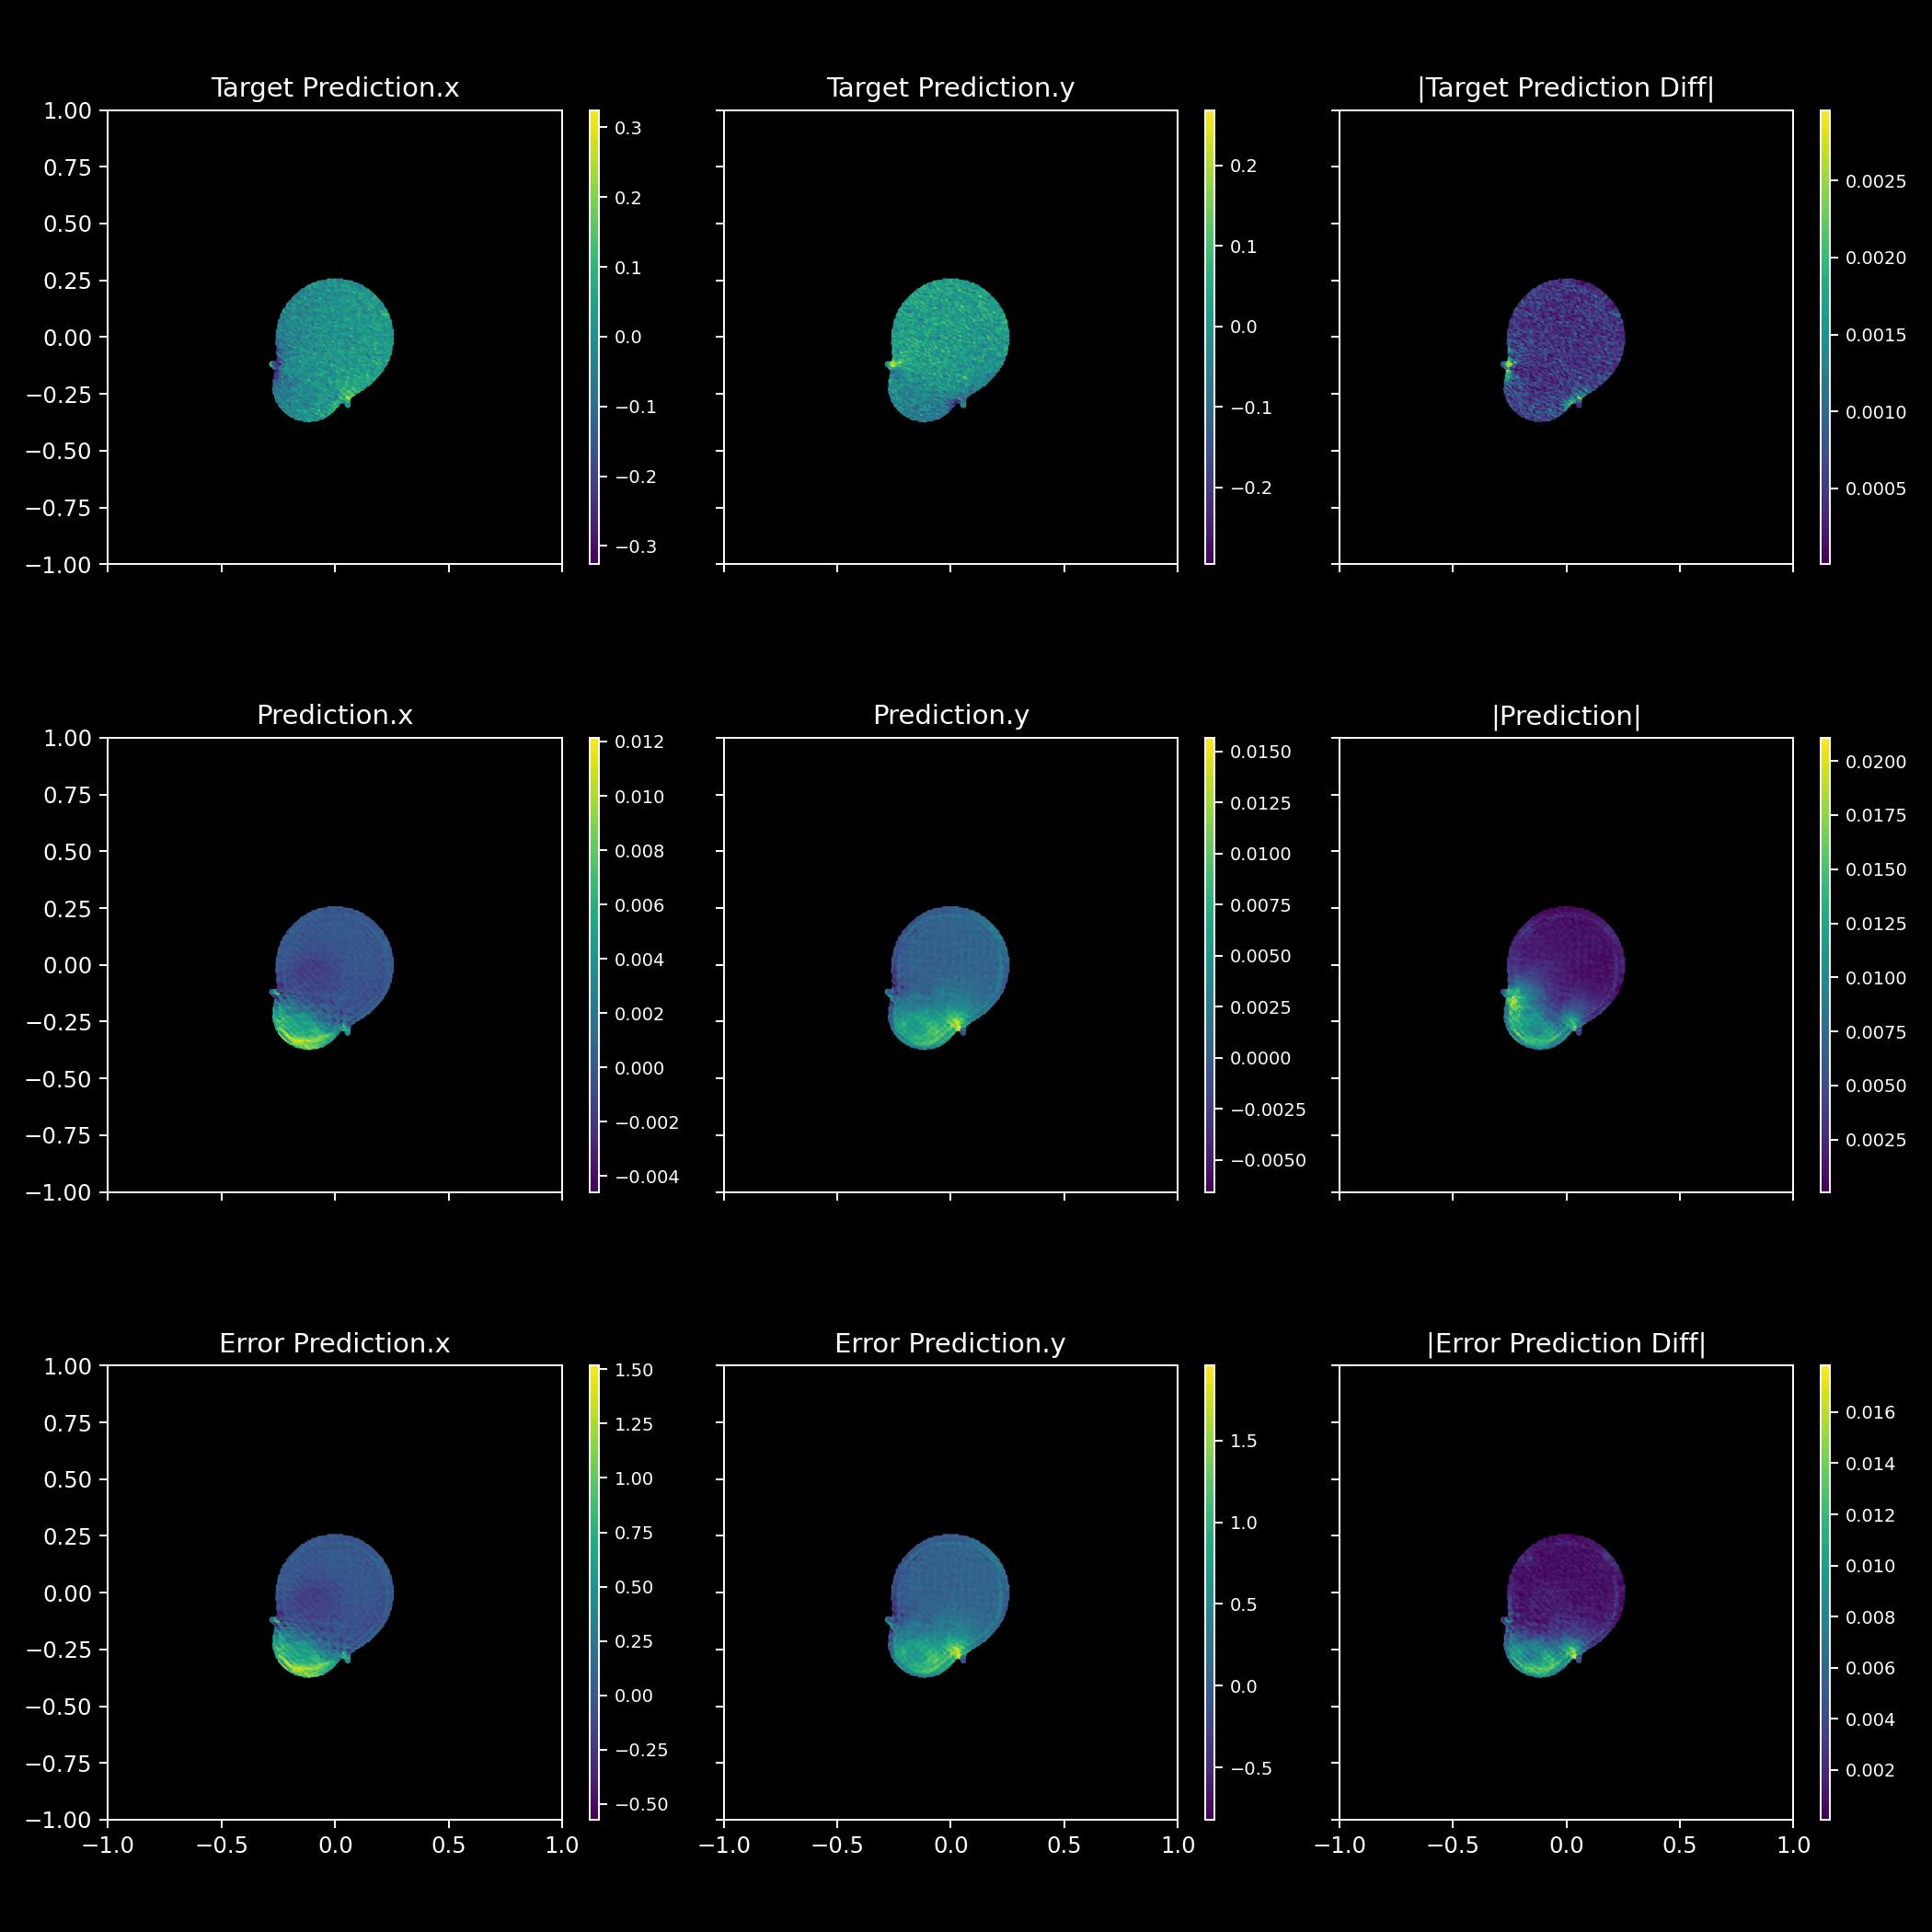

In [199]:
fig, axis = plt.subplots(3, 3, figsize=(12,12), sharex = True, sharey = True, squeeze = False)

def scatter(fig, axis, x, y, c, title):
    im = axis.scatter(x.detach().cpu().numpy(), y.detach().cpu().numpy(), c = c.detach().cpu().numpy(), s = 2)
    axis.axis([-1, 1, -1, 1])
    axis.set_aspect('equal', adjustable='box')
    ax1_divider = make_axes_locatable(axis)
    cax1 = ax1_divider.append_axes("right", size="2%", pad="6%")
    cb1 = fig.colorbar(im, cax=cax1,orientation='vertical')
    cb1.ax.tick_params(labelsize=8) 
    axis.set_title(title)

scatter(fig, axis[0,0], initialPosition[:,0], initialPosition[:,1], (gtPosition - pos2)[:,0] / attributes[0]['dt'], 'Target Prediction.x')
scatter(fig, axis[0,1], initialPosition[:,0], initialPosition[:,1], (gtPosition - pos2)[:,1] / attributes[0]['dt'], 'Target Prediction.y')
scatter(fig, axis[0,2], initialPosition[:,0], initialPosition[:,1], torch.linalg.norm(gtPosition - pos2, dim = 1), '|Target Prediction Diff|')

scatter(fig, axis[1,0], initialPosition[:,0], initialPosition[:,1], (predictions)[:,0], 'Prediction.x')
scatter(fig, axis[1,1], initialPosition[:,0], initialPosition[:,1], (predictions)[:,1], 'Prediction.y')
scatter(fig, axis[1,2], initialPosition[:,0], initialPosition[:,1], torch.linalg.norm(predictions, dim = 1), '|Prediction|')

scatter(fig, axis[2,0], initialPosition[:,0], initialPosition[:,1], (pos2 + predictions[:,:2]  / attributes[0]['dt'] - gtPosition)[:,0], 'Error Prediction.x')
scatter(fig, axis[2,1], initialPosition[:,0], initialPosition[:,1], (pos2 + predictions[:,:2] / attributes[0]['dt'] - gtPosition)[:,1], 'Error Prediction.y')
scatter(fig, axis[2,2], initialPosition[:,0], initialPosition[:,1], torch.linalg.norm(pos2 + predictions[:,:2] - gtPosition, dim = 1), '|Error Prediction Diff|')

fig.tight_layout()

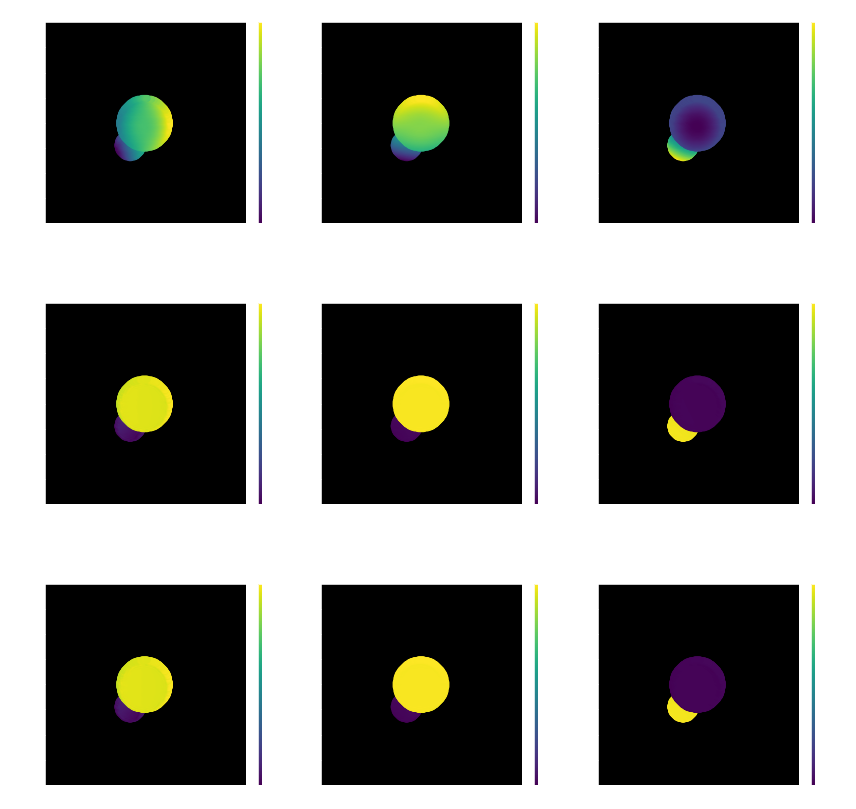

In [153]:
fig, axis = plt.subplots(3, 3, figsize=(12,12), sharex = True, sharey = True, squeeze = False)

def scatter(fig, axis, x, y, c, title):
    im = axis.scatter(x.detach().cpu().numpy(), y.detach().cpu().numpy(), c = c.detach().cpu().numpy())
    axis.axis([-1, 1, -1, 1])
    axis.set_aspect('equal', adjustable='box')
    ax1_divider = make_axes_locatable(axis)
    cax1 = ax1_divider.append_axes("right", size="2%", pad="6%")
    cb1 = fig.colorbar(im, cax=cax1,orientation='vertical')
    cb1.ax.tick_params(labelsize=8) 
    axis.set_title(title)
    
scatter(fig, axis[0,0], initialPosition[:,0], initialPosition[:,1], (initialVelocity - vel2)[:,0], 'Vel Diff.x')
scatter(fig, axis[0,1], initialPosition[:,0], initialPosition[:,1], (initialVelocity - vel2)[:,1], 'Vel Diff.y')
scatter(fig, axis[0,2], initialPosition[:,0], initialPosition[:,1], torch.linalg.norm(initialVelocity - vel2, dim = 1), '|Vel Diff|')

scatter(fig, axis[1,0], initialPosition[:,0], initialPosition[:,1], (initialPosition - pos2)[:,0], 'Pos Diff.x')
scatter(fig, axis[1,1], initialPosition[:,0], initialPosition[:,1], (initialPosition - pos2)[:,1], 'Pos Diff.y')
scatter(fig, axis[1,2], initialPosition[:,0], initialPosition[:,1], torch.linalg.norm(initialPosition - pos2, dim = 1), '|Pos Diff|')
        
scatter(fig, axis[2,0], initialPosition[:,0], initialPosition[:,1], (gtPosition - initialPosition)[:,0], 'GT Pos Diff.x')
scatter(fig, axis[2,1], initialPosition[:,0], initialPosition[:,1], (gtPosition - initialPosition)[:,1], 'GT Pos Diff.y')
scatter(fig, axis[2,2], initialPosition[:,0], initialPosition[:,1], torch.linalg.norm(gtPosition - initialPosition, dim = 1), '|GT Pos Diff|')

# scatter(fig, axis[2,0], initialPosition[:,0], initialPosition[:,1], (predictions)[:,0], 'Prediction.x')
# scatter(fig, axis[2,1], initialPosition[:,0], initialPosition[:,1], (predictions)[:,1], 'Prediction.y')
# scatter(fig, axis[2,2], initialPosition[:,0], initialPosition[:,1], torch.linalg.norm(predictions, dim = 1), '|Prediction|')

fig.tight_layout()

In [206]:
# loss = model.li[:,None] * (pos2 + predictions[:,:2] / attributes[0]['dt'] - gtPosition)
loss = pos2 + predictions[:,:2] / attributes[0]['dt'] - gtPosition
print(loss)

tensor([[ 0.7890,  0.1570],
        [ 0.7938,  0.1678],
        [ 0.8685,  0.3360],
        ...,
        [-0.0093, -0.0346],
        [-0.0413,  0.0508],
        [-0.0454,  0.0433]], device='cuda:0', grad_fn=<SubBackward0>)


In [288]:
random.seed(args.networkseed)
torch.manual_seed(args.networkseed)
torch.cuda.manual_seed(args.networkseed)
np.random.seed(args.networkseed)
boundaryFeatures = None

model = None
if args.network == 'default':
    model = RbfNet(fluidFeatures.shape[1], boundaryFeatures.shape[1] if boundaryFeatures is not None else 0, layers = layers, coordinateMapping = coordinateMapping, n = n, m = m, windowFn = windowFn, rbf_x = rbf_x, rbf_y = rbf_y, batchSize = args.cutlassBatchSize, normalized = args.normalized)
if args.network == 'split':
    model = RbfSplitNet(fluidFeatures.shape[1], boundaryFeatures.shape[1] if boundaryFeatures is not None else 0, layers = layers, coordinateMapping = coordinateMapping, n = n, m = m, windowFn = windowFn, rbf_x = rbf_x, rbf_y = rbf_y, batchSize = args.cutlassBatchSize, normalized = args.normalized)
if args.network == 'interleaved':
    model = RbfInterleaveNet(fluidFeatures.shape[1], boundaryFeatures.shape[1] if boundaryFeatures is not None else 0, layers = layers, coordinateMapping = coordinateMapping, n = n, m = m, windowFn = windowFn, rbf_x = rbf_x, rbf_y = rbf_y, batchSize = args.cutlassBatchSize, normalized = args.normalized)
if args.network == 'input':
    model = RbfInputNet(fluidFeatures.shape[1], boundaryFeatures.shape[1] if boundaryFeatures is not None else 0, layers = layers, coordinateMapping = coordinateMapping, n = n, m = m, windowFn = windowFn, rbf_x = rbf_x, rbf_y = rbf_y, batchSize = args.cutlassBatchSize, normalized = args.normalized)
if args.network == 'output':
    model = RbfOutputNet(fluidFeatures.shape[1], boundaryFeatures.shape[1] if boundaryFeatures is not None else 0, layers = layers, coordinateMapping = coordinateMapping, n = n, m = m, windowFn = windowFn, rbf_x = rbf_x, rbf_y = rbf_y, batchSize = args.cutlassBatchSize, normalized = args.normalized)


lr = initialLR
optimizer = Adam(model.parameters(), lr=lr, weight_decay=args.weight_decay)
model = model.to(device)


In [289]:
print(model)

RbfNet(
  (convs): ModuleList(
    (0): RbfConv(4, 32, dim=2)
    (1): RbfConv(64, 64, dim=2)
    (2): RbfConv(64, 64, dim=2)
    (3): RbfConv(64, 3, dim=2)
  )
  (fcs): ModuleList(
    (0): Linear(in_features=4, out_features=32, bias=True)
    (1): Linear(in_features=64, out_features=64, bias=True)
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): Linear(in_features=64, out_features=3, bias=True)
  )
)


In [290]:
from tqdm.notebook import tqdm

In [297]:
bdata = [0, -1]
unroll = 4

dataRows = torch.zeros((len(bdata), unroll, dataCache.shape[1], dataCache.shape[2]))

for ib, b in enumerate(bdata):
    for iu, u in enumerate(range(unroll)):
        currRow = dataCache[b + iu,:,:]
        dataRows[ib, iu, :, :] = currRow
dataRows = dataRows.to(device) 
print(dataRows.shape)

torch.Size([2, 4, 3130, 12])


In [310]:
fluidBatches = torch.hstack([torch.ones(dataRows.shape[2]) * i for i in range(len(bdata))]).to(device)
print(attributes)
# print(fluidBatches.shape)

{'support': 0.035287954, 'targetNeighbors': 50, 'restDensity': 1000, 'dt': 0.008, 'time': 0.9200000000000007, 'radius': 0.004990470487242752, 'area': 7.82407231601377e-05}


In [311]:
initialPosition = torch.vstack([r[0,:,:2] for r in dataRows])
boundaryPositions = None
fluidFeatures = torch.vstack([r[0,:,6:10] for r in dataRows])
boundaryFeatures = None
boundaryBatches = None

for iu, u in enumerate(range(unroll)):
    
    print(model(initialPosition, boundaryPositions, fluidFeatures, boundaryFeatures, attributes, fluidBatches, boundaryBatches))
    
    print(iu)
    print(initialPosition.shape, initialPosition)
    
    initialPosition = torch.vstack([r[iu,:,:2] for r in dataRows])
    boundaryPositions = None
    fluidFeatures = torch.vstack([r[iu,:,6:10] for r in dataRows])
    boundaryFeatures = None
    boundaryBatches = None
    break

tensor([[ 0.0014,  0.0020, -0.0023],
        [ 0.0012,  0.0019, -0.0028],
        [ 0.0018,  0.0020, -0.0023],
        ...,
        [-0.0001,  0.0033, -0.0017],
        [-0.0004,  0.0042, -0.0029],
        [-0.0014,  0.0039, -0.0036]], device='cuda:0', grad_fn=<DivBackward0>)
0
torch.Size([6260, 2]) tensor([[-0.1831, -0.5115],
        [-0.1742, -0.5115],
        [-0.1654, -0.5115],
        ...,
        [ 0.1622,  0.1300],
        [ 0.1517,  0.1378],
        [ 0.1674,  0.1261]], device='cuda:0')


In [236]:
model.train()

for i in (t:= tqdm(range(2048))):
    optimizer.zero_grad()
    predictions = model(initialPosition, boundaryPositions, fluidFeatures, boundaryFeatures, attributes[0], fluidBatches, boundaryBatches)
    loss = torch.linalg.norm(pos2 + predictions[:,:2] * attributes[0]['dt'] - gtPosition, dim = 1) / attributes[0]['dt']
    lossTerm = torch.mean(loss)
    lossTerm.backward()
    optimizer.step()
    t.set_description('%g' % lossTerm.detach().item()) 
    

  0%|          | 0/2048 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [227]:
print(predictions)

tensor([[ 2.2392e-08, -5.9932e-06,  0.0000e+00],
        [ 2.2392e-08, -5.9932e-06,  0.0000e+00],
        [ 2.2392e-08, -5.9932e-06,  0.0000e+00],
        ...,
        [ 2.2392e-08, -5.9932e-06,  0.0000e+00],
        [ 2.2392e-08, -5.9932e-06,  0.0000e+00],
        [ 2.2392e-08, -5.9932e-06,  0.0000e+00]], device='cuda:0',
       grad_fn=<DivBackward0>)


<IPython.core.display.Javascript object>


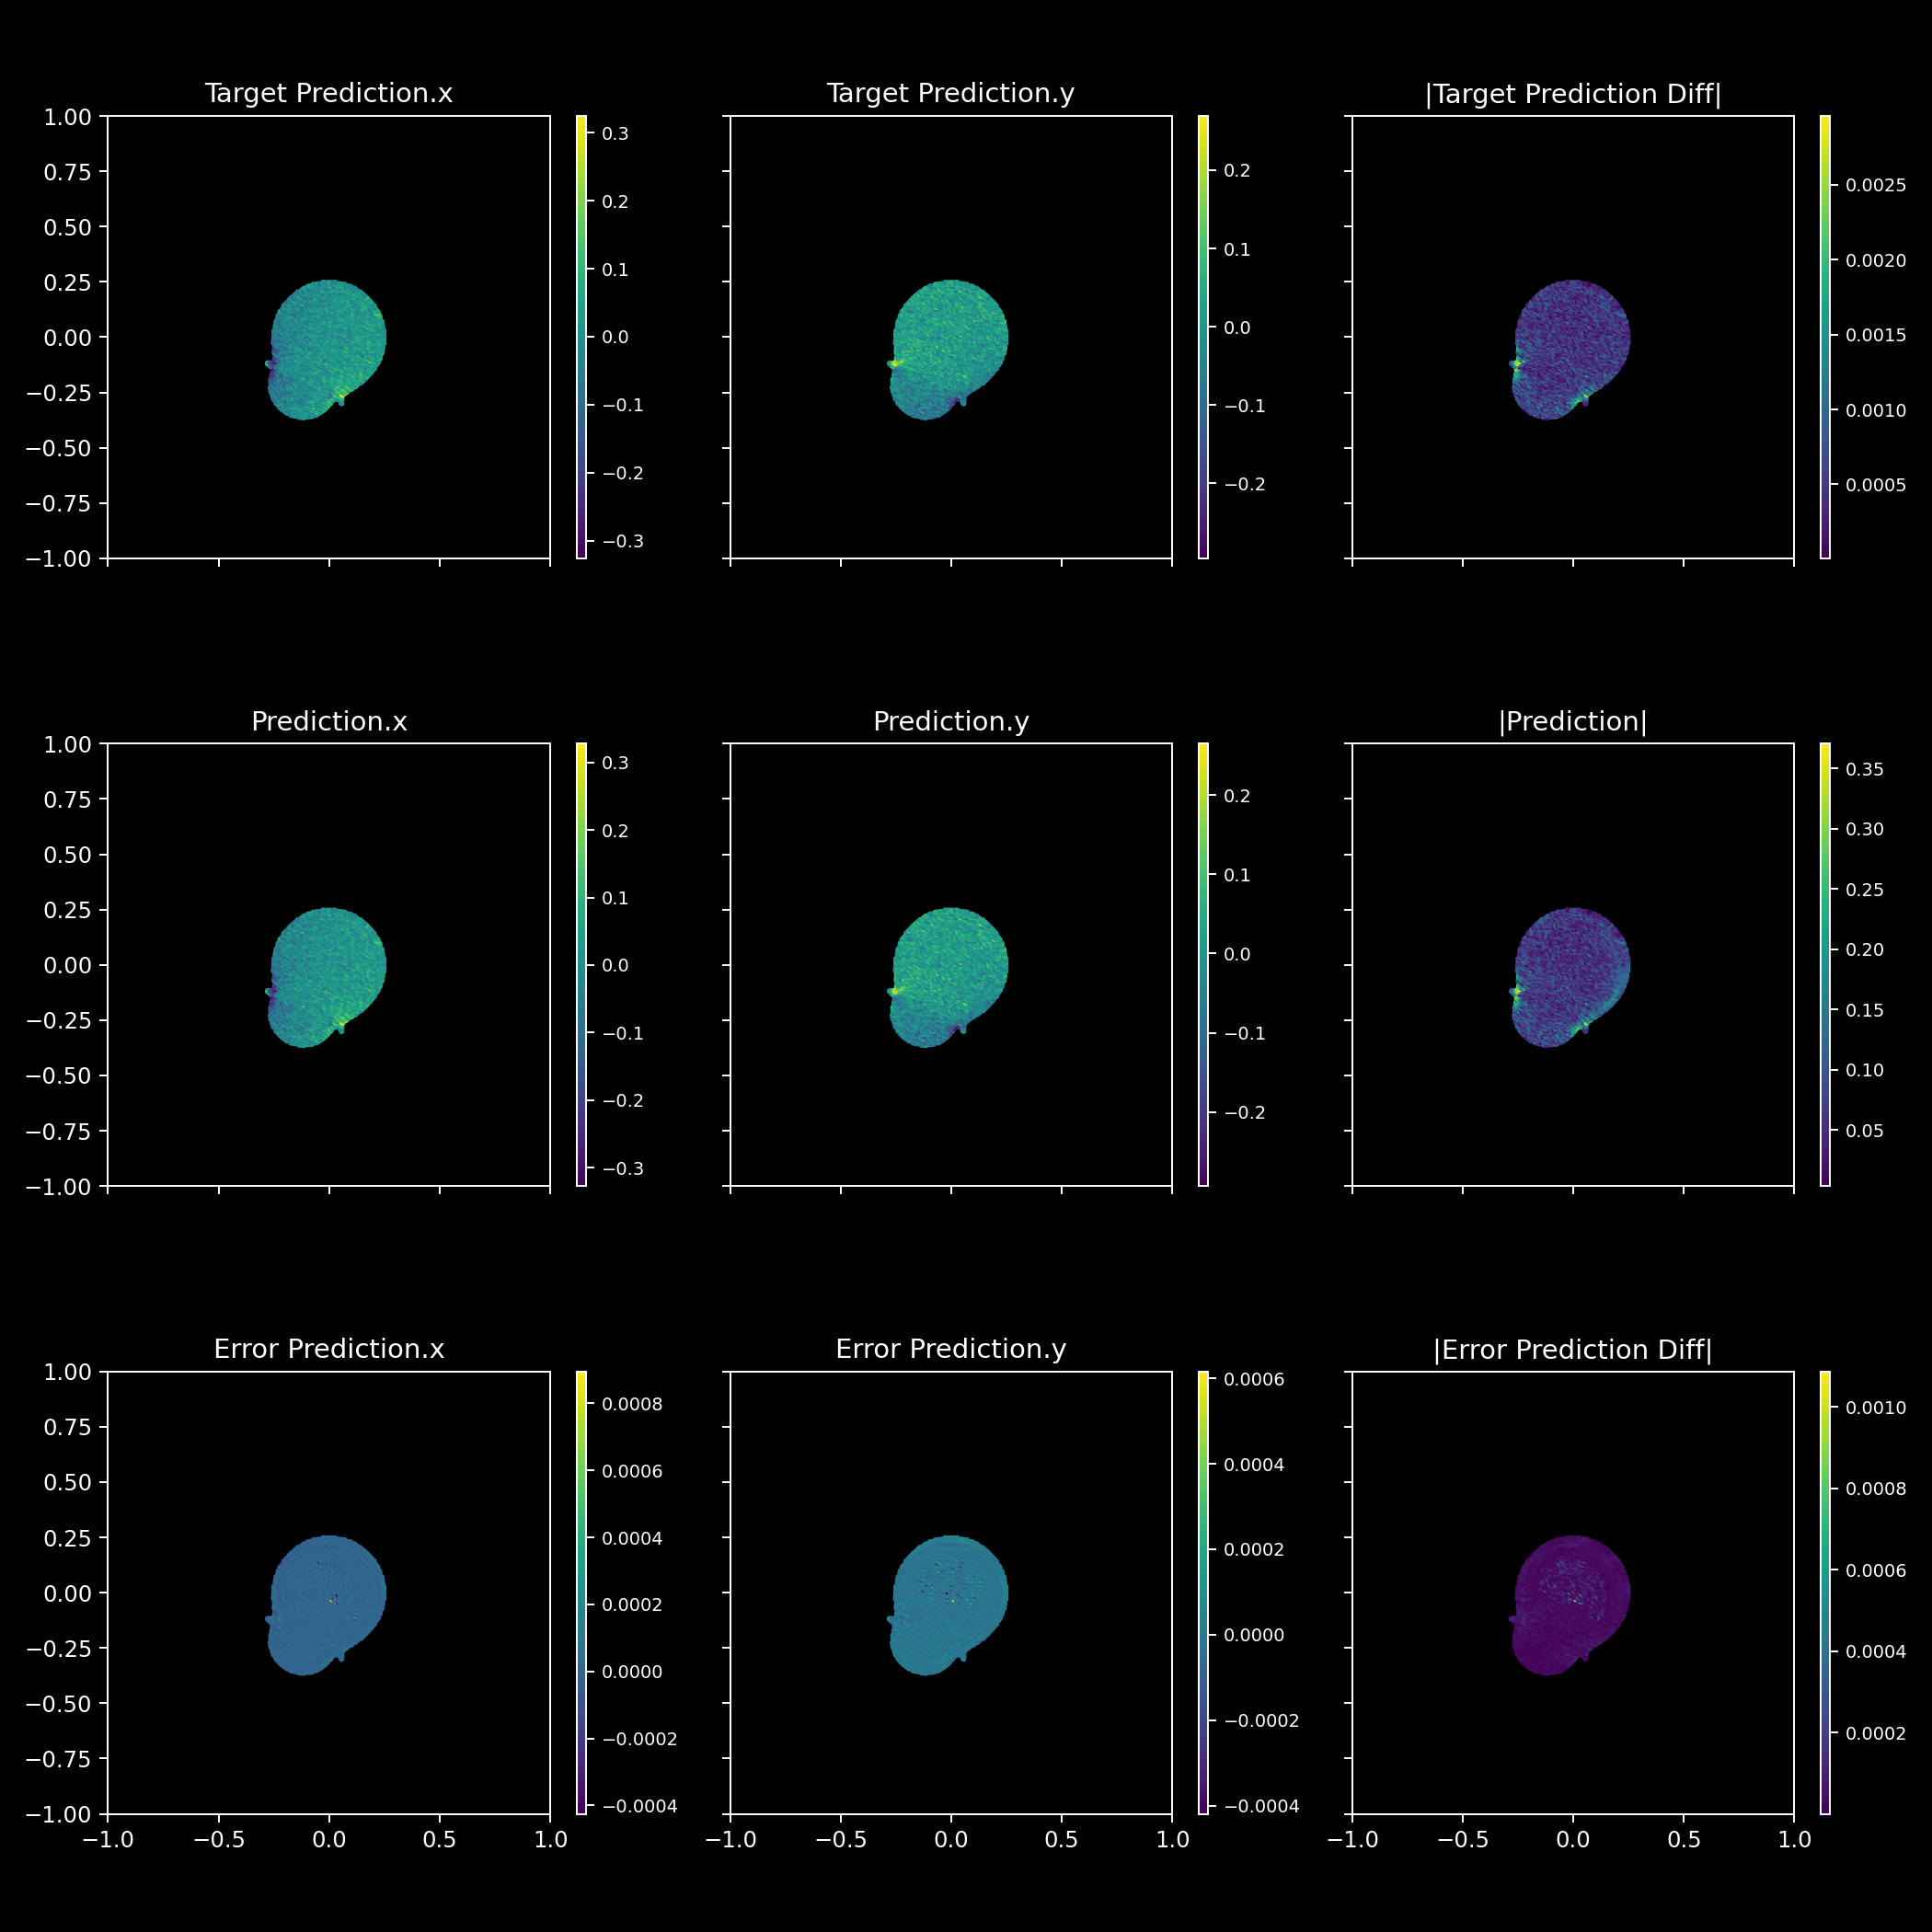

In [235]:
fig, axis = plt.subplots(3, 3, figsize=(12,12), sharex = True, sharey = True, squeeze = False)

def scatter(fig, axis, x, y, c, title):
    im = axis.scatter(x.detach().cpu().numpy(), y.detach().cpu().numpy(), c = c.detach().cpu().numpy(), s = 2)
    axis.axis([-1, 1, -1, 1])
    axis.set_aspect('equal', adjustable='box')
    ax1_divider = make_axes_locatable(axis)
    cax1 = ax1_divider.append_axes("right", size="2%", pad="6%")
    cb1 = fig.colorbar(im, cax=cax1,orientation='vertical')
    cb1.ax.tick_params(labelsize=8) 
    axis.set_title(title)

scatter(fig, axis[0,0], initialPosition[:,0], initialPosition[:,1], (gtPosition - pos2)[:,0] / attributes[0]['dt'], 'Target Prediction.x')
scatter(fig, axis[0,1], initialPosition[:,0], initialPosition[:,1], (gtPosition - pos2)[:,1] / attributes[0]['dt'], 'Target Prediction.y')
scatter(fig, axis[0,2], initialPosition[:,0], initialPosition[:,1], torch.linalg.norm(gtPosition - pos2, dim = 1), '|Target Prediction Diff|')

scatter(fig, axis[1,0], initialPosition[:,0], initialPosition[:,1], (predictions)[:,0], 'Prediction.x')
scatter(fig, axis[1,1], initialPosition[:,0], initialPosition[:,1], (predictions)[:,1], 'Prediction.y')
scatter(fig, axis[1,2], initialPosition[:,0], initialPosition[:,1], torch.linalg.norm(predictions, dim = 1), '|Prediction|')

scatter(fig, axis[2,0], initialPosition[:,0], initialPosition[:,1], (pos2 + predictions[:,:2] * attributes[0]['dt'] - gtPosition)[:,0], 'Error Prediction.x')
scatter(fig, axis[2,1], initialPosition[:,0], initialPosition[:,1], (pos2 + predictions[:,:2] * attributes[0]['dt'] - gtPosition)[:,1], 'Error Prediction.y')
scatter(fig, axis[2,2], initialPosition[:,0], initialPosition[:,1], torch.linalg.norm(pos2 + predictions[:,:2] * attributes[0]['dt'] - gtPosition, dim = 1), '|Error Prediction Diff|')

fig.tight_layout()

In [64]:
fluidPositions, boundaryPositions, fluidFeatures, boundaryFeatures, fluidGravity, fluidBatches, boundaryBatches, groundTruths, attributes = \
    loadBatch(train_ds, bdata, constructFluidFeatures, unroll, frameDistance, augmentAngle = augmentAngle, augmentJitter = augmentJitter, jitterAmount = jitterAmount, adjustForFrameDistance = adjustForFrameDistance)    


predictedPositions = fluidPositions.to(device)
predictedVelocity = fluidFeatures[:,1:3].to(device)

bLosses = []
#         boundaryPositions = boundaryPositions.to(device)
fluidFeatures = fluidFeatures.to(device)
#         boundaryFeatures = boundaryFeatures.to(device)
fluidBatches = fluidBatches.to(device)
#         boundaryBatches = boundaryBatches.to(device)

gravity = torch.zeros_like(predictedVelocity)

difference = fluidPositions - torch.tensor([0,0], dtype = fluidPositions.dtype, device = fluidPositions.device)
distance = torch.linalg.norm(difference,axis=1) + 1e-7
difference = difference / distance[:, None]
fluidGravity = -0.5 * 10**2 * difference * (distance)[:,None]**2

#         fluidGravity = 

gravity = fluidGravity[:,:2].to(device)



In [65]:
from tqdm.notebook import tqdm

In [96]:
def runNetwork(initialPosition, initialVelocity, attributes, frameDistance, gravity, fluidFeatures, boundaryPositions, boundaryFeatures, groundTruth, model,fluidBatches, boundaryBatches, li):
    # if verbose:
    #     print('running network with')
    #     print('initialPosition', initialPosition[:4])
    #     print('initialVelocity', initialVelocity[:4])
    #     print('dt', dt)
    #     print('frameDistance', frameDistance)        
    #     print('gravity', gravity[:4])
    #     print('fluidFeatures', fluidFeatures[:4])
    #     print('boundaryPositions', boundaryPositions[:4])
    #     print('boundaryFeatures', boundaryFeatures[:4])
    #     print('fluidBatches', fluidBatches)
    #     print('boundaryBatches', boundaryBatches)
    #     print('li', li)
# Heun's method:
    # vel2 = initialVelocity + frameDistance * attributes['dt'] * gravity
    # pos2 = initialPosition + frameDistance * attributes['dt'] * (initialVelocity + vel2) / 2
# semi implicit euler
    d = (frameDistance) * ((frameDistance) + 1) / 2
#     print(gravity)

    difference = initialPosition - torch.tensor([0,0], dtype = initialPosition.dtype, device = initialPosition.device)
    distance = torch.linalg.norm(difference,axis=1) + 1e-7
    difference = difference / distance[:, None]
    gravity = -0.5 * 10**2 * difference * (distance)[:,None]**2

    vel2 = initialVelocity + frameDistance * attributes['dt'] * gravity
    pos2 = initialPosition + frameDistance * attributes['dt'] * initialVelocity# + d * attributes['dt']**2 * gravity
        
    fluidFeatures = torch.hstack((fluidFeatures[:,0][:,None], vel2, fluidFeatures[:,3:]))
    # if verbose:
    #     print('calling network with' )
    #     print('d', d)
    #     print('vel2', vel2[:4])
    #     print('pos2', pos2[:4])
    #     print('fluidFeatures', fluidFeatures[:4])
    
    predictions = model(initialPosition, boundaryPositions, fluidFeatures, boundaryFeatures, attributes, fluidBatches, boundaryBatches)
#     predictions[:,:] = 0

    predictedVelocity = (pos2 + predictions[:,:2] - initialPosition) / (frameDistance * attributes['dt'])
    predictedPositions = pos2 + predictions[:,:2]
    
#     print(pos2, initialPosition)
#     print(vel2, initialVelocity)

    if li:
        loss =  model.li * computeLoss(predictedPositions, predictedVelocity, groundTruth.to(pos2.device), predictions)
    else:
        loss =   computeLoss(predictedPositions, predictedVelocity, groundTruth.to(pos2.device), predictions)

    return loss, predictedPositions, predictedVelocity
    

def processBatch(model, device, li, e, unroll, train_ds, bdata, frameDistance, augmentAngle = False, augmentJitter = False, jitterAmount = 0.01, adjustForFrameDistance = True):
    with record_function("process batch"): 
        fluidPositions, boundaryPositions, fluidFeatures, boundaryFeatures, fluidGravity, fluidBatches, boundaryBatches, groundTruths, attributes = \
            loadBatch(train_ds, bdata, constructFluidFeatures, unroll, frameDistance, augmentAngle = augmentAngle, augmentJitter = augmentJitter, jitterAmount = jitterAmount, adjustForFrameDistance = adjustForFrameDistance)    


        predictedPositions = fluidPositions.to(device)
        predictedVelocity = fluidFeatures[:,1:3].to(device)

        bLosses = []
#         boundaryPositions = boundaryPositions.to(device)
        fluidFeatures = fluidFeatures.to(device)
#         boundaryFeatures = boundaryFeatures.to(device)
        fluidBatches = fluidBatches.to(device)
#         boundaryBatches = boundaryBatches.to(device)

        gravity = torch.zeros_like(predictedVelocity)
    
        difference = fluidPositions - torch.tensor([0,0], dtype = fluidPositions.dtype, device = fluidPositions.device)
        distance = torch.linalg.norm(difference,axis=1) + 1e-7
        difference = difference / distance[:, None]
        fluidGravity = -0.5 * 10**2 * difference * (distance)[:,None]**2
                    
#         fluidGravity = 
    
        gravity = fluidGravity[:,:2].to(device)
        
    #     gravity[:,1] = -9.81

        for u in range(unroll):
            with record_function("prcess batch[unroll]"): 
    #         loss, predictedPositions, predictedVelocity = runNetwork(fluidPositions.to(device), inputData['fluidVelocity'].to(device), attributes['dt'], frameDistance, gravity, fluidFeatures, boundaryPositions.to(device), boundaryFeatures.to(device), groundTruths[0], model, None, None, True)
                loss, predictedPositions, predictedVelocity = runNetwork(predictedPositions, predictedVelocity, attributes[0], frameDistance, gravity, fluidFeatures, boundaryPositions, boundaryFeatures, groundTruths[u], model, fluidBatches, boundaryBatches, li)

                batchedLoss = []
                for i in range(len(bdata)):
                    L = loss[fluidBatches == i]
                    Lterms = (torch.mean(L), torch.max(torch.abs(L)), torch.min(torch.abs(L)), torch.std(L))            
                    batchedLoss.append(torch.hstack(Lterms))
                batchedLoss = torch.vstack(batchedLoss).unsqueeze(0)
                bLosses.append(batchedLoss)

        bLosses = torch.vstack(bLosses)
        maxLosses = torch.max(bLosses[:,:,1], dim = 0)[0]
        minLosses = torch.min(bLosses[:,:,2], dim = 0)[0]
        meanLosses = torch.mean(bLosses[:,:,0], dim = 0)
        stdLosses = torch.mean(bLosses[:,:,3], dim = 0)


        del predictedPositions, predictedVelocity, boundaryPositions, fluidFeatures, boundaryFeatures, fluidBatches, boundaryBatches

        bLosses = bLosses.transpose(0,1)

        return bLosses, meanLosses, minLosses, maxLosses, stdLosses



    
def processDataLoaderIter(iterations, e, rollout, ds, dataLoader, dataIter, model, optimizer, train = True, prefix = '', augmentAngle = False, augmentJitter = False, jitterAmount = 0.01):
    with record_function("prcess data loader"): 
        pbl = gtqdms[args.gpu + args.gpus]
        losses = []
        batchIndices = []

        if train:
            model.train(True)
        else:
            model.train(False)

        with portalocker.Lock('README.md', flags = 0x2, timeout = None):
            pbl.reset(total=iterations)
        i = 0
        for b in range(iterations):
            try:
                bdata = next(dataIter)
            except:
                dataIter = iter(dataLoader)
                bdata = next(dataIter)
                
            with record_function("prcess data loader[batch]"): 
                if train:
                    optimizer.zero_grad()
                batchLosses, meanLosses, minLosses, maxLosses, stdLosses = processBatch(model, device, True, e, rollout, ds, bdata, frameDistance, augmentAngle, augmentJitter, jitterAmount, adjustForFrameDistance = args.adjustForFrameDistance)
                # print(torch.max(model.ni))
                
                batchIndices.append(np.array(bdata))
                losses.append(batchLosses.detach().cpu().numpy())

                with record_function("prcess data loader[batch] - backward"): 
                    sumLosses = torch.mean(batchLosses[:,:,0]) #+ torch.mean(batchLosses[:,:,1])
                    if train:
                        sumLosses.backward()
                        optimizer.step()
                lossString = np.array2string(torch.mean(batchLosses[:,:,0],dim=0).detach().cpu().numpy(), formatter={'float_kind':lambda x: "%.2e" % x})
                batchString = str(np.array2string(np.array(bdata), formatter={'float_kind':lambda x: "%.2f" % x, 'int':lambda x:'%04d' % x}))

                with portalocker.Lock('README.md', flags = 0x2, timeout = None):
                    pbl.set_description('%8s[gpu %d]: %3d [%1d] @ %1.1e: :  %s -> %.2e' %(prefix, args.gpu, e, rollout, lr, batchString, sumLosses.detach().cpu().numpy()))
                    pbl.update()
                    if prefix == 'training':
                        # pb.set_description('[gpu %d] Learning: %1.4e Validation: %1.4e' %(args.gpu, np.mean(np.mean(np.vstack(losses)[:,:,0], axis = 1)), 0))
                        pb.set_description('[gpu %d] %90s - Learning: %1.4e' %(args.gpu, shortLabel, np.mean(np.mean(np.vstack(losses)[:,:,0], axis = 1))))
                    if prefix == 'validation':
                        pb.set_description('[gpu %d] Learning: %1.4e Validation: %1.4e' %(args.gpu, trainLoss, np.mean(np.mean(np.vstack(losses)[:,:,0], axis = 1))))
                    pb.update()
#                 i = i + 1
#                 if i > 100:
#                     break
        bIndices  = np.hstack(batchIndices)
        losses = np.vstack(losses)

        # idx = np.argsort(bIndices)
        # bIndices = bIndices[idx]
        # losses = losses[idx]

        epochLoss = losses
        return epochLoss


training = {}
# training_fwd = {}
validation = {}
testing = {}



In [97]:

trainLoss = 0
validationLoss = 0
train_iter = iter(train_dataloader)

trainingEpochLosses = []
trainingEpochLosses2 = []
validationLosses = []

unroll = 2

random.seed(args.seed)
torch.manual_seed(args.seed)
torch.cuda.manual_seed(args.seed)
np.random.seed(args.seed)
# if args.verbose:
    # print('Start of training')

gtqdms = []
if args.verbose:
    print('Setting up tqdm progress bars')

with portalocker.Lock('README.md', flags = 0x2, timeout = None):
    for g in range(args.gpus):
        gtqdms.append(tqdm(range(0, (epochs) * args.iterations), position = g, leave = True))
    for g in range(args.gpus):
        gtqdms.append(tqdm(range(1, epochs + 1), position = args.gpus + g, leave = True))
# print(torch.cuda.current_device())

pb = gtqdms[args.gpu]
with portalocker.Lock('README.md', flags = 0x2, timeout = None):
    pb.set_description('[gpu %d]' %(args.gpu))

# pb.reset(total=len(train_dataloader))
for epoch in range(epochs):
    losses = []

    unroll = max(args.minUnroll, min(epoch // 2 + 1, args.maxUnroll))
    # trainingEpochLoss = processDataLoaderIter(args.iterations, epoch, epoch // 2 + 1, train_ds, train_dataloader, train_iter, model, optimizer, True, prefix = 'training', augmentAngle=args.argumentAngle, augmentJitter=args.augmentJitter, jitterAmount=args.jitterAmount)
    trainingEpochLoss = processDataLoaderIter(args.iterations, epoch, unroll, train_ds, train_dataloader, train_iter, model, optimizer, True, prefix = 'training', augmentAngle=args.augmentAngle, augmentJitter=args.augmentJitter, jitterAmount=args.jitterAmount)

#     trainingEpochLoss = processDataLoader(epoch,unroll, train_ds, train_dataloader, model, optimizer, True, prefix = 'training')
    trainingEpochLosses.append(trainingEpochLoss)
    # torch.save(model.state_dict(), './trainingData/%s/model_%03d.torch' % (exportString, epoch))
    if epoch % 5 == 0 and epoch > 0:
        lr = lr * 0.5
        for param_group in optimizer.param_groups:
            param_group['lr'] = 0.5 * param_group['lr']
    torch.save(model.state_dict(), './%s/%s/model_%03d.torch' % (args.output, exportString, epoch))

  0%|          | 0/25000 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

In [98]:
# bdata = iter(train_dataloader)
# print(next(bdata))
bdata = [0]
# train_ds[0]

In [100]:
fluidPositions, boundaryPositions, fluidFeatures, boundaryFeatures, fluidGravity, fluidBatches, boundaryBatches, groundTruths, attributes = \
    loadBatch(train_ds, bdata, constructFluidFeatures, 32, frameDistance, augmentAngle = False, augmentJitter = False, jitterAmount = 0.0, adjustForFrameDistance = False)    


predictedPositions = fluidPositions.to(device)
predictedVelocity = fluidFeatures[:,1:3].to(device)

bLosses = []
# boundaryPositions = boundaryPositions.to(device)
fluidFeatures = fluidFeatures.to(device)
# boundaryFeatures = boundaryFeatures.to(device)
fluidBatches = fluidBatches.to(device)
# boundaryBatches = boundaryBatches.to(device)

gravity = torch.zeros_like(predictedVelocity)
gravity = fluidGravity[:,:2].to(device)

positions = [torch.clone(predictedPositions).cpu()]
velocities = [torch.clone(predictedVelocity).cpu()]


for u in range(32):
    with record_function("prcess batch[unroll]"): 
#         loss, predictedPositions, predictedVelocity = runNetwork(fluidPositions.to(device), inputData['fluidVelocity'].to(device), attributes['dt'], frameDistance, gravity, fluidFeatures, boundaryPositions.to(device), boundaryFeatures.to(device), groundTruths[0], model, None, None, True)
        loss, predictedPositions, predictedVelocity = runNetwork(
            predictedPositions, predictedVelocity, attributes[0], frameDistance, gravity, fluidFeatures, 
            boundaryPositions, boundaryFeatures, groundTruths[u], model, fluidBatches, boundaryBatches, True)

        positions.append(torch.clone(predictedPositions).cpu().detach())
        velocities.append(torch.clone(predictedVelocity).cpu().detach())
#         positions.)
        batchedLoss = []
        for i in range(len(bdata)):
            L = loss[fluidBatches == i]
            Lterms = (torch.mean(L), torch.max(torch.abs(L)), torch.min(torch.abs(L)), torch.std(L))            
            batchedLoss.append(torch.hstack(Lterms))
        batchedLoss = torch.vstack(batchedLoss).unsqueeze(0)
        bLosses.append(batchedLoss)



In [101]:
print(torch.max(torch.linalg.norm(positions[1] - positions[-1], axis = 1)))
print(torch.max(torch.linalg.norm(positions[0] - groundTruths[-1][:,:2], axis = 1)))


tensor(0.1561)
tensor(0.4136)


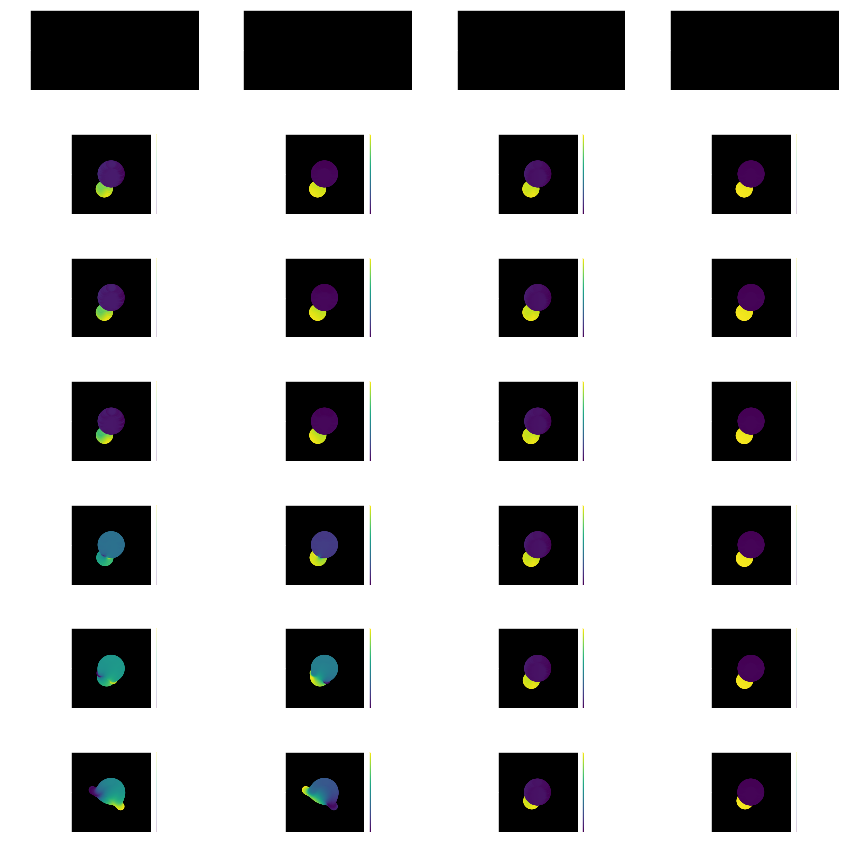

In [102]:
fig, axis = plt.subplots(7, 4, figsize=(12,12), sharex = False, sharey = False, squeeze = False)

def scatter(fig, axis, x, y, c, title):
    im = axis.scatter(x, y, c = c)
    axis.axis([-1, 1, -1, 1])
    axis.set_aspect('equal', adjustable='box')
    ax1_divider = make_axes_locatable(axis)
    cax1 = ax1_divider.append_axes("right", size="2%", pad="6%")
    cb1 = fig.colorbar(im, cax=cax1,orientation='vertical')
    cb1.ax.tick_params(labelsize=8) 
    axis.set_title(title)
    
for i, p in enumerate([1,2,4,8,16,32]):
    if p > 0:
        scatter(fig, axis[i + 1,0], groundTruths[p - 1][:,0], groundTruths[p - 1][:,1], groundTruths[p - 1][:,2], 'v.x')
        scatter(fig, axis[i + 1,1], groundTruths[p - 1][:,0], groundTruths[p - 1][:,1], groundTruths[p - 1][:,3], 'v.y')
    scatter(fig, axis[i + 1,2], positions[p][:,0], positions[p][:,1], velocities[p][:,0], 'v.x')
    scatter(fig, axis[i + 1,3], positions[p][:,0], positions[p][:,1], velocities[p][:,1], 'v.y')


fig.tight_layout()